# Step 0 - Configuration and setup of dependencies

In [7]:
# Dependencies installation
!pip install matplotlib
!pip install pandas
!pip install torch torchvision torchaudio


In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader

import pandas as pd

# Step 1 - review dataset

In [21]:
import pandas as pd

# Specify the path to your Parquet file
image_dir = "../datasets/easy-500"
parquet_file_path = f"{image_dir}/images.parquet"
labels_parquet_file_path = f"{image_dir}/labels.parquet"

# Load the Parquet file into a DataFrame
img_labels = pd.read_parquet(parquet_file_path, engine='pyarrow')  # or engine='fastparquet'

df_labels = pd.read_parquet(labels_parquet_file_path)

print(df_labels)

def dump_images(df):
  for i, row in df.iterrows():
    image = cv2.imdecode(np.frombuffer(row['image'], np.uint8), cv2.IMREAD_COLOR)
    success = cv2.imwrite(f'../{image_dir}/{i}.jpg', image)

# Now you can work with the DataFrame `df`
print(img_labels.head())

dump_images(img_labels)

       image_id    x    y  orientation  radius  class
0             0  269  450     0.000000      17      0
1             0  533  299     0.663225      45      1
2             0  539  427     0.610865      46      1
3             0  365  148     0.488692      45      1
4             0  472  136     2.426008      40      1
...         ...  ...  ...          ...     ...    ...
11495       499  356  363     0.575959      37      2
11496       499  477  371     2.268928      41      2
11497       499  934   74     2.076942      45      2
11498       499  525  283     0.506145      46      2
11499       499  284  397     5.916666      38      2

[11500 rows x 6 columns]
   id                                              image
0   0  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
1   1  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
2   2  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
3   3  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
4   4  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00

(4.0, 2.0)
torch.Size([7, 7, 13])
image_id         0.0
x              269.0
y              450.0
orientation      0.0
radius          17.0
class            0.0
Name: 0, dtype: float64
cell x: 0, cell y: 0, Object: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
cell x: 1, cell y: 0, Object: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
cell x: 2, cell y: 0, Object: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
cell x: 3, cell y: 0, Object: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
cell x: 4, cell y: 0, Object: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
cell x: 5, cell y: 0, Object: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
cell x: 6, cell y: 0, Object: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
cell x: 0, cell y: 1, Object: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
cell x: 1, cell y: 1, Object: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

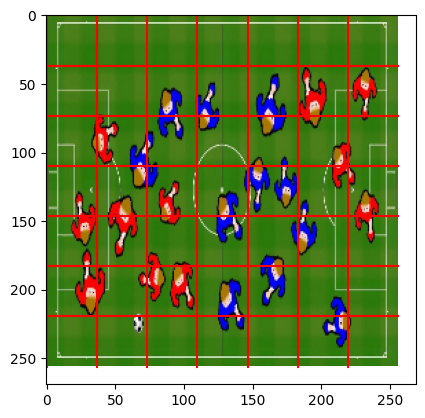

In [97]:
import torch
from torch.utils.data import Dataset
import pandas as pd
import numpy as np

class YOLODataset(Dataset):
    def __init__(self, parquet_path, img_dir, S=7, B=2, C=3, target_size=(256, 256)):
        # Load the annotations
        self.img_labels = pd.read_parquet(parquet_path)
        self.S = S
        self.B = B
        self.C = C
        self.img_dir = img_dir
        self.target_size = target_size
        self.property_count = 5

    def __len__(self):
        # Number of unique images
        return self.df['image_id'].nunique()

    def __getitem__(self, idx):
        # Filter entries for the current image
        label_data = self.img_labels[self.img_labels['image_id'] == idx]

        img_path = f"{self.img_dir}/{int(self.img_labels.iloc[idx]['image_id'])}.jpg"

        # Load image with cv2 and convert to RGB
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Calculate the aspect ratio, note that the y and x is swapped in order        
        aspect_ratio = image.shape[1]/ self.target_size[1], image.shape[0] / self.target_size[0]
        print(aspect_ratio)

        # Resize image
        image = cv2.resize(image, self.target_size, interpolation=cv2.INTER_LINEAR)

        image_debug = image

        # Normalize image
        image = image / 255.0
        image = np.transpose(image, (2, 0, 1))  # From HWC to CHW
        image = torch.tensor(image, dtype=torch.float)

        # Initialize the target tensor with YOLOv1 structure [S][S][5xB + C]
        target = torch.zeros((self.S, self.S, 5*self.B + self.C))
        print(target.shape)

        print(self.img_labels.iloc[idx])
        
        # Loop through objects (this part may need to be adjusted based on your data structure)
        for _, row in label_data.iterrows():
            # Normalize x, y, and radius
            x, y, radius = row['x'] / (self.target_size[0] * aspect_ratio[0]), row['y'] / (self.target_size[1] * aspect_ratio[1]), row['radius']
            #print(f"X: {x} y: {y}, radius: {radius}")
            
            # Determine the grid cell. Note: floor operation converts to int
            grid_x, grid_y = int(self.S * x), int(self.S * y)

            #print(f"grid_x: {grid_x} grid_y: {grid_y}")
            
            # Assuming 'class' is already an integer that can be one-hot encoded
            class_one_hot = torch.zeros((self.C,))
            class_one_hot[int(row['class'])] = 1
            
            # Populate the target tensor
            # Note: This example assumes B=1 for simplicity. You'll need to adjust it to handle multiple bounding boxes.
            obj_data = torch.tensor([1, x, y, radius, row['orientation'], *class_one_hot])
   
            # Debugging data data for this object
            # obj_data = [1, x*self.S - grid_x, y*self.S - grid_y, radius, row['orientation'], *class_one_hot]
            
            # Find an empty box slot
            box_found = False
            for b in range(self.B):
                if target[grid_x, grid_y, b*5] == 0:  # If the confidence score (first of the 5*B properties) is 0, the slot is empty
                    test_tensor = torch.tensor([1, x, y, radius, row['orientation']], dtype=torch.float32)
                    target[grid_x, grid_y, b*5:b*5+5] = torch.tensor([1, x, y, radius, row['orientation']], dtype=torch.float32)
                    target[grid_x, grid_y, 5*self.B:] = class_one_hot  # Class probabilities are the same for all boxes in the cell
                    box_found = True
                    break
            
            if not box_found:
                # If no break occurred, all bounding boxes for this cell are filled
                assert False, f"More objects in cell ({grid_x}, {grid_y}) than allowed by B={self.B}"   
            
        return image, image_debug, target

# Example usage
S = 7
image_size = (256,256)
dataset = YOLODataset(parquet_path=labels_parquet_file_path, img_dir=image_dir, S=S, B=2, C=3)
image, image_debug, target = dataset.__getitem__(0)

for y in range(S):
    for x in range(S):
        print(f"cell x: {x}, cell y: {y}, Object: {target[x][y]}")

print(target.shape)

print(image.shape)

plt.imshow(image_debug);

for i in range(7):
    plt.plot([i* (image_size[0]/S), i * (image_size[0]/S)], [0, image_size[0]], color='red')
    plt.plot([0, image_size[1]], [i* (image_size[1]/S), i * (image_size[1]/S)], color='red')    

# Step 2 - Setup the Model

For testing, lets create our simple yolo model

In [98]:
import torch
import torch.nn as nn

class SimpleYOLO(nn.Module):
    def __init__(self, S=7, B=2, C=3, image_size=(256, 256), color_depth=3, feature_map_size=16, stride=2, linear_size=512):
        super(SimpleYOLO, self).__init__()
        self.S = S
        self.B = B
        self.C = C

        # Adjusted for input images and using stride for max pooling
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=color_depth, out_channels=feature_map_size, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(feature_map_size),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=stride)  # Using stride explicitly for clarity
        )
        
        # Calculate the size of the feature map after pooling
        conv_output_size = (image_size[0] // stride) * (image_size[1] // stride)

        # Flatten the output for the linear layers
        self.flatten_size = feature_map_size * conv_output_size
        self.fc1 = nn.Linear(self.flatten_size, linear_size)
        self.fc2 = nn.Linear(linear_size, self.S * self.S * (5 * self.B + self.C))  # Explicit output size
        
    def forward(self, x):
        x = self.layer1(x)
        x = x.view(-1, self.flatten_size)  # Flatten the output for the linear layer
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        # Reshape the output tensor to explicitly match the label's expected output format
        x = x.view(-1, self.S, self.S, 5*self.B + self.C)
        return x

# Example model initialization with corrected dimensions
model = SimpleYOLO(S=7, B=2, C=3)
print(model)


SimpleYOLO(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=262144, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=637, bias=True)
)


Now lets perform our training